# Import

In [1]:
import copy
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from timezonefinder import TimezoneFinder
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error
)
from models.sarimax_2 import Model
import pickle

# Constants

In [2]:
HISTORY_LENGTH = 2*24
FORECAST_LENGTH = 24

CONSUMPTION_DATA_PATH = "data/psh_microgrid_total_power.csv"
WEATHER_DATA_PATH = "data/open-meteo-18.88N99.04E309m.csv"
MODEL_PATH = f"models/sarimax_{HISTORY_LENGTH}_{FORECAST_LENGTH}.pkl"

LATITUDE = 18.852
LONGITUDE = 98.994
TIMEZONE = TimezoneFinder().certain_timezone_at(lat=LATITUDE, lng=LONGITUDE)

TIMESTAMP_COLUMN = "timestamp"
CONSUMPTION_POWER_COLUMN = "total_power"

# Utils

In [3]:
def get_history(timeseries: pd.DataFrame, timestamp: pd.Timestamp, hours_n: int) -> pd.DataFrame:
    history = timeseries[timestamp - pd.Timedelta(hours=hours_n) : timestamp - pd.Timedelta(hours=1)]
    if len(history) != hours_n:
        return None
    # print(type(history))
    return history

In [4]:
def get_actual_forecast(timeseries: pd.DataFrame, timestamp: pd.Timestamp, hours_n: int) -> pd.DataFrame:
    actual_forecast = timeseries[timestamp : timestamp  + pd.Timedelta(hours=hours_n-1)]
    if len(actual_forecast) != hours_n:
        return None
    # print(type(actual_forecast))
    return actual_forecast

# Data load

In [5]:
consumption_df = pd.read_csv(CONSUMPTION_DATA_PATH, usecols=[TIMESTAMP_COLUMN, CONSUMPTION_POWER_COLUMN], parse_dates=[TIMESTAMP_COLUMN]) # skiprows=[1, 2]

In [6]:
weather_df = pd.read_csv(WEATHER_DATA_PATH, parse_dates=[TIMESTAMP_COLUMN]) 

# Data preprocessing

In [7]:
consumption_df[TIMESTAMP_COLUMN] = pd.to_datetime(consumption_df[TIMESTAMP_COLUMN], utc=False)
consumption_df[TIMESTAMP_COLUMN] = consumption_df[TIMESTAMP_COLUMN].dt.tz_convert(TIMEZONE)
consumption_df = consumption_df.sort_values(by=TIMESTAMP_COLUMN)
consumption_df = consumption_df.set_index(TIMESTAMP_COLUMN)

In [8]:
weather_df[TIMESTAMP_COLUMN] = pd.to_datetime(weather_df[TIMESTAMP_COLUMN], utc=False)

In [9]:
weather_df[TIMESTAMP_COLUMN] = weather_df[TIMESTAMP_COLUMN].dt.tz_localize(TIMEZONE)

In [10]:
weather_df = weather_df.sort_values(by=TIMESTAMP_COLUMN)
weather_df = weather_df.set_index(TIMESTAMP_COLUMN)

In [11]:
consumption_weather_df = consumption_df.merge(weather_df, left_index=True, right_index=True)

In [12]:
consumption_weather_df

,total_power,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),weather_code (wmo code),pressure_msl (hPa),surface_pressure (hPa),...,wind_speed_10m (km/h),wind_speed_100m (km/h),wind_direction_10m (°),wind_direction_100m (°),is_day (),sunshine_duration (s),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²)
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-12-14 15:00:00+07:00,23922.065,26.9,56,17.3,29.4,0.0,0.0,0,1012.0,977.1,...,0.7,0.7,180,180,1,3600.00,492.0,334.0,158.0,556.1
2021-12-14 16:00:00+07:00,17697.354,26.8,56,17.2,29.0,0.0,0.0,1,1011.7,976.8,...,2.9,3.3,180,186,1,3600.00,406.0,313.0,93.0,689.4
2021-12-14 17:00:00+07:00,8098.858,25.3,71,19.7,28.4,0.0,0.0,1,1011.7,976.7,...,4.3,7.9,185,180,1,3600.00,209.0,144.0,65.0,537.7
2021-12-14 18:00:00+07:00,6417.736,21.9,82,18.7,24.1,0.0,0.0,1,1012.2,976.7,...,7.4,8.4,223,187,0,1262.11,37.0,19.0,18.0,159.8
2021-12-14 19:00:00+07:00,6270.340,23.5,68,17.3,25.5,0.0,0.0,0,1012.6,977.3,...,4.4,6.6,235,167,0,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-05 12:00:00+07:00,10006.421,31.2,68,24.6,38.3,0.0,0.0,0,1009.3,975.0,...,6.1,7.4,135,133,1,3600.00,809.0,660.0,149.0,734.7
2023-10-05 13:00:00+07:00,19655.796,31.5,66,24.4,38.7,0.0,0.0,0,1007.8,973.6,...,6.4,8.0,142,144,1,3600.00,843.0,694.0,149.0,761.4
2023-10-05 14:00:00+07:00,19371.399,31.6,67,24.7,38.6,0.0,0.0,1,1005.8,971.7,...,6.5,7.7,124,127,1,3600.00,773.0,628.0,145.0,729.6


# Data Splitting

In [13]:
timestamp_for_split = pd.Timestamp(year=2023, month=1, day=1, tz=TIMEZONE)

In [14]:
train_ts = consumption_weather_df[:timestamp_for_split]
test_ts = consumption_weather_df[timestamp_for_split:]

In [15]:
segment = get_actual_forecast(test_ts, timestamp_for_split, 7*24)

In [16]:
segment_consumption_power = segment[CONSUMPTION_POWER_COLUMN]

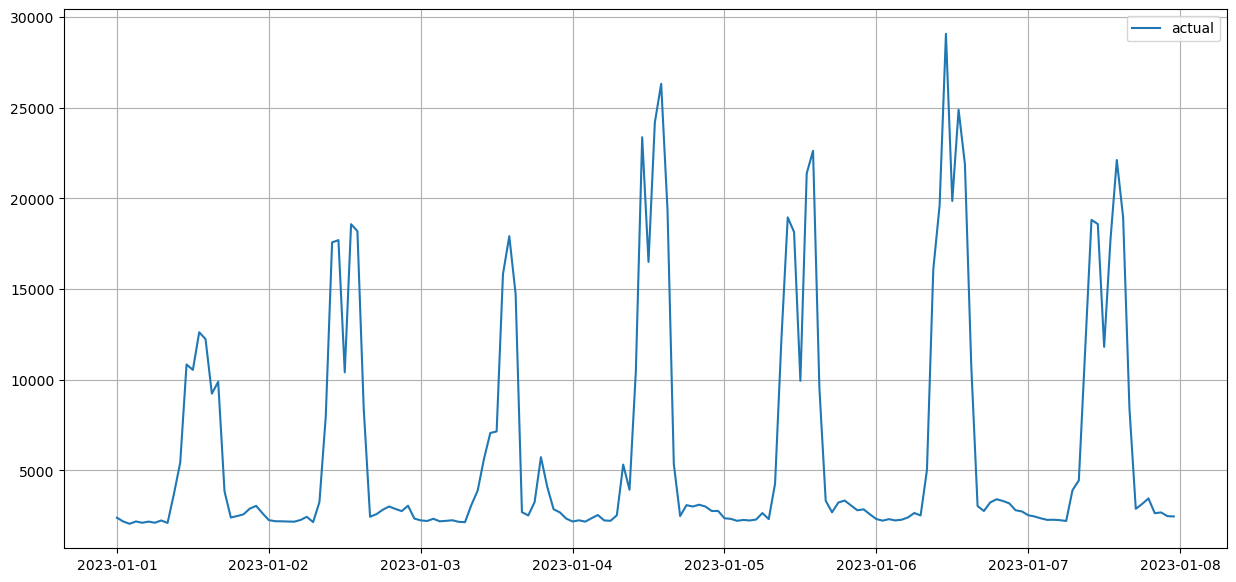

In [17]:
plt.figure(figsize=(15, 7))
# plt.plot(forecast, color="r", label="model")
# plt.axvspan(df.index[-FORECAST_HORIZON], df.index[-1], alpha=0.5, color="lightgrey")
plt.plot(segment_consumption_power, label="actual")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
train_ts[CONSUMPTION_POWER_COLUMN].to_csv("train_consumption_power_history.csv")
train_ts.drop(columns=[CONSUMPTION_POWER_COLUMN]).to_csv("train_weather_history.csv")

## collect_test_and_solution_data

In [19]:
timestamp_test = pd.Timestamp(year=2023, month=2, day=10, tz=TIMEZONE)

In [20]:
# 6379 / (6379 + 9094)

In [21]:
def collect_test_data(test_timeseries: pd.DataFrame, history_length, forecast_length):
    test_ts_consumption = test_timeseries[CONSUMPTION_POWER_COLUMN]
    test_ts_weather = test_timeseries.drop(columns=[CONSUMPTION_POWER_COLUMN])
    lagged_table_consumption = pd.DataFrame()
    usage_column_for_kaggle = "Public"
    timestamps = test_timeseries.index
    for timestamp in tqdm(timestamps):
        history = get_history(test_timeseries, timestamp, history_length)
        forecast_actual = get_actual_forecast(test_timeseries, timestamp, forecast_length)
        if history is None or forecast_actual is None:
            continue     
        consumption_lagged_row = pd.DataFrame([ [usage_column_for_kaggle] + [timestamp] + list(history[CONSUMPTION_POWER_COLUMN].values) + list(forecast_actual[CONSUMPTION_POWER_COLUMN].values) ], 
                                               columns=["Usage"] + [TIMESTAMP_COLUMN] + [f"history_-{history_length-i}" for i in range(history_length)] +  [f"actual_{i}" for i in range(forecast_length)])
        lagged_table_consumption = pd.concat([lagged_table_consumption, consumption_lagged_row], ignore_index=True)
    return test_ts_consumption, test_ts_weather, lagged_table_consumption

In [22]:
test_ts_consumption, test_ts_weather, lagged_table_consumption = collect_test_data(test_ts, HISTORY_LENGTH, FORECAST_LENGTH)

100%|██████████| 6379/6379 [00:21<00:00, 295.60it/s]


In [23]:
lagged_table_consumption_shuffled = lagged_table_consumption.sample(frac=1, random_state=1).reset_index().drop(columns=["index"])

In [25]:
lagged_table_consumption_shuffled.head()

,Usage,timestamp,history_-48,history_-47,history_-46,history_-45,history_-44,history_-43,history_-42,history_-41,...,actual_14,actual_15,actual_16,actual_17,actual_18,actual_19,actual_20,actual_21,actual_22,actual_23
0,Public,2023-05-24 12:00:00+07:00,10015.655,13097.048,3898.870,4575.623,2763.242,2660.464,3091.484,2952.767,...,2241.939,2243.733,2192.810,2214.323,2631.932,2524.225,4975.401,15936.508,19718.706,19239.969
1,Public,2023-08-26 11:00:00+07:00,11737.736,10184.587,10592.683,7474.058,4724.619,3193.931,2706.374,3280.045,...,2208.681,2165.529,2250.591,2296.975,2408.975,2470.346,2629.412,2508.784,6481.499,8790.139
2,Public,2023-02-21 19:00:00+07:00,2928.452,3072.099,2769.171,2614.965,2465.817,2427.493,2252.473,2154.754,...,6199.311,17526.946,16445.814,11295.202,18752.510,20153.545,18172.637,9120.544,2749.054,2617.800
3,Public,2023-06-29 09:00:00+07:00,6394.800,14627.740,15751.433,7653.719,12975.060,13969.252,11589.479,8565.758,...,2544.099,2648.936,2432.989,2570.371,2515.315,2652.659,2587.427,2899.592,2746.022,3100.500
4,Public,2023-07-28 03:00:00+07:00,2599.349,2337.062,2347.490,2620.818,2631.602,3468.374,7109.229,11411.248,...,2275.207,2747.107,2928.023,2921.124,2677.236,2573.737,2711.415,2511.663,2256.353,2230.347


In [26]:
test_table_consumption = lagged_table_consumption_shuffled.drop(columns=["Usage"] + [f"actual_{i}" for i in range(FORECAST_LENGTH)])
solution_table = lagged_table_consumption_shuffled.drop(columns=[f"history_-{HISTORY_LENGTH-i}" for i in range(HISTORY_LENGTH)])

In [27]:
test_table_consumption.head()

,timestamp,history_-48,history_-47,history_-46,history_-45,history_-44,history_-43,history_-42,history_-41,history_-40,...,history_-10,history_-9,history_-8,history_-7,history_-6,history_-5,history_-4,history_-3,history_-2,history_-1
0,2023-05-24 12:00:00+07:00,10015.655,13097.048,3898.870,4575.623,2763.242,2660.464,3091.484,2952.767,2678.590,...,2272.478,2312.366,2504.760,2387.756,2601.485,2757.794,7670.864,16842.622,16691.255,17914.534
1,2023-08-26 11:00:00+07:00,11737.736,10184.587,10592.683,7474.058,4724.619,3193.931,2706.374,3280.045,3062.477,...,2394.751,2194.753,2476.730,2310.797,2356.527,2537.690,2571.153,4643.299,14115.690,16701.067
2,2023-02-21 19:00:00+07:00,2928.452,3072.099,2769.171,2614.965,2465.817,2427.493,2252.473,2154.754,2089.748,...,13959.493,21028.381,16858.248,9994.245,12037.869,13665.284,7667.946,11037.088,3459.660,4408.138
3,2023-06-29 09:00:00+07:00,6394.800,14627.740,15751.433,7653.719,12975.060,13969.252,11589.479,8565.758,2846.009,...,2616.761,2483.733,2366.364,2485.110,2628.040,2690.557,2521.363,2863.602,3010.692,2955.929
4,2023-07-28 03:00:00+07:00,2599.349,2337.062,2347.490,2620.818,2631.602,3468.374,7109.229,11411.248,17837.435,...,2456.907,2628.719,3225.339,2767.342,2713.134,2611.434,2520.454,2441.368,2315.123,1994.791


In [28]:
solution_table.head()

,Usage,timestamp,actual_0,actual_1,actual_2,actual_3,actual_4,actual_5,actual_6,actual_7,...,actual_14,actual_15,actual_16,actual_17,actual_18,actual_19,actual_20,actual_21,actual_22,actual_23
0,Public,2023-05-24 12:00:00+07:00,11612.270,19049.100,22878.932,20071.528,3082.311,2592.475,3095.508,3042.549,...,2241.939,2243.733,2192.810,2214.323,2631.932,2524.225,4975.401,15936.508,19718.706,19239.969
1,Public,2023-08-26 11:00:00+07:00,6718.382,3682.140,6869.621,6638.495,6707.388,4814.618,2476.983,3127.200,...,2208.681,2165.529,2250.591,2296.975,2408.975,2470.346,2629.412,2508.784,6481.499,8790.139
2,Public,2023-02-21 19:00:00+07:00,3722.132,5535.354,3606.023,2353.618,2342.230,2320.117,2286.034,2479.048,...,6199.311,17526.946,16445.814,11295.202,18752.510,20153.545,18172.637,9120.544,2749.054,2617.800
3,Public,2023-06-29 09:00:00+07:00,7352.863,13306.212,17546.046,6771.112,9559.888,9698.384,9559.189,5886.557,...,2544.099,2648.936,2432.989,2570.371,2515.315,2652.659,2587.427,2899.592,2746.022,3100.500
4,Public,2023-07-28 03:00:00+07:00,2106.291,2059.454,2195.438,2529.502,2504.160,2659.106,5701.876,8028.462,...,2275.207,2747.107,2928.023,2921.124,2677.236,2573.737,2711.415,2511.663,2256.353,2230.347


In [29]:
number_of_test_cases = len(solution_table)
sample_submission_table = pd.DataFrame({f"forecast_{i}": list(range(number_of_test_cases)) for i in range(FORECAST_LENGTH)})
sample_submission_table[TIMESTAMP_COLUMN] = lagged_table_consumption_shuffled[TIMESTAMP_COLUMN]
sample_submission_table = sample_submission_table.set_index(TIMESTAMP_COLUMN).reset_index()

In [30]:
sample_submission_table.head()

,timestamp,forecast_0,forecast_1,forecast_2,forecast_3,forecast_4,forecast_5,forecast_6,forecast_7,forecast_8,...,forecast_14,forecast_15,forecast_16,forecast_17,forecast_18,forecast_19,forecast_20,forecast_21,forecast_22,forecast_23
0,2023-05-24 12:00:00+07:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2023-08-26 11:00:00+07:00,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,2023-02-21 19:00:00+07:00,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
3,2023-06-29 09:00:00+07:00,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
4,2023-07-28 03:00:00+07:00,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4


In [31]:
test_table_consumption.to_csv("data/test_cases_consumption_power.csv")
test_ts_weather.to_csv("data/test_weather_time_series.csv")
solution_table.to_csv("data/solution_table_consumption_power.csv")
sample_submission_table.to_csv("data/submission_table_consumption_power.csv")